# Extrator de características: Dicionário


## Exemplo local

Imports necessários

In [60]:
 
import cv2
import os
import matplotlib.pyplot as plt
import sys
import numpy as np
from numpy.linalg import norm

In [61]:
# Function definition to plot histogram
def plot_histogram(image_path):
    """
    Carrega uma imagem, calcula o histograma de cores para cada canal (Azul, Verde, Vermelho)
    e exibe o resultado em um gráfico.
    """
    # Tenta carregar a imagem a partir do caminho fornecido
    image = cv2.imread(image_path)
    
    # Verifica se a imagem foi carregada com sucesso. Se não, exibe um erro.
    if image is None:
        print(f"Erro: Não foi possível carregar a imagem do caminho: {image_path}")
        return

    # Separa os canais de cores (OpenCV carrega imagens em formato BGR por padrão)
    colors = ('b', 'g', 'r')
    
    # Cria uma figura para o plot
    plt.figure()
    plt.title('Histograma de Cores')
    plt.xlabel('Intensidade do Pixel (Bins)')
    plt.ylabel('Número de Pixels')

    # Itera sobre cada canal de cor (b, g, r) para calcular e plotar o histograma
    for i, color in enumerate(colors):
        # cv2.calcHist(images, channels, mask, histSize, ranges)
        # images: a imagem de entrada como uma lista [image]
        # channels: o índice do canal para o qual calcular o histograma [i]
        # mask: máscara para calcular o histograma em uma região específica (None para a imagem inteira)
        # histSize: número de bins (níveis de intensidade), 256 para o espectro completo de 0 a 255
        # ranges: o intervalo de valores dos pixels [0, 256]
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        
        # Plota o histograma do canal atual
        plt.plot(hist, color=color)
        plt.xlim([0, 256]) # Define o limite do eixo X

    # Exibe o gráfico do histograma
    plt.show()


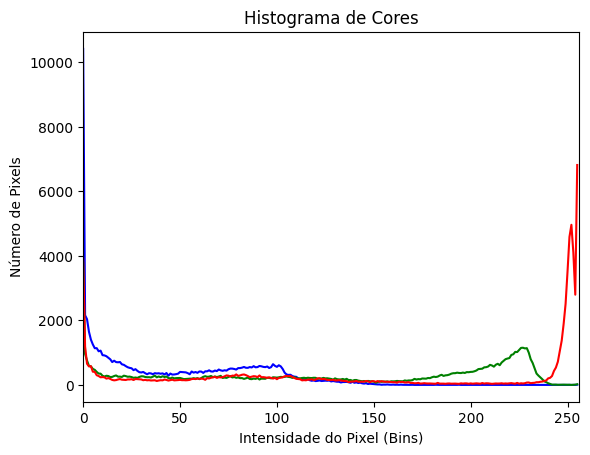

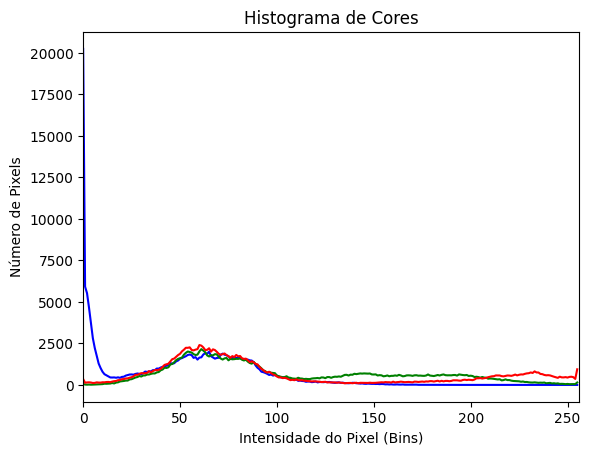

In [62]:
# paths - Execute
image_path1 = 'dataset_sunflowers/4746638094_f5336788a0_n.jpg'
plot_histogram(image_path1)
image_path2 = 'dataset_sunflowers/4755075329_1fccc69d4e.jpg'
plot_histogram(image_path2)

## 3 diferentes funções de extração de características de imagens

### 1º  - Extrai um histograma de cores 3D normalizado nos canais HSV.
    

In [83]:
def draw_keypoints(img, keypoints):
    """
    Desenha os keypoints detectados sobre a imagem original.
    """
    img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, color=(0, 255, 0), flags=0)
    return img_with_keypoints

def extract_color_histogram(img_path):
    image = cv2.imread(img_path)
    if image is None:
        print(f"[WARNING] Não foi possível carregar a imagem: {img_path}")
        return None
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()


### 2º - Extrai pontos-chave (keypoints) e descritores usando o algoritmo ORB.

In [64]:
def extract_orb_features(img):
    """
    Extrai pontos-chave (keypoints) e descritores usando o algoritmo ORB.
    ORB é rápido e eficiente para encontrar características locais.
    Retorna os keypoints e seus descritores.
    """
    # Converte a imagem para escala de cinza, pois o ORB funciona em um único canal
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Inicializa o detector ORB com um limite de 500 features
    orb = cv2.ORB_create(nfeatures=500)
    
    # Detecta os pontos-chave e calcula seus descritores
    # Keypoints: a localização dos pontos de interesse
    # Descriptors: um vetor que descreve a vizinhança de cada keypoint
    keypoints, descriptors = orb.detectAndCompute(gray_image, None)
    
    return keypoints, descriptors


### 3º - Extrai um vetor de características semânticas usando uma rede neural pré-treinada (ResNet50).

In [65]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

In [66]:
def extract_deep_features(img_path):
    """
    Extrai um vetor de características semânticas usando uma rede neural pré-treinada (ResNet50).
    Este vetor representa o conteúdo de alto nível da imagem.
    """
    # Carrega o modelo ResNet50 pré-treinado na base de dados ImageNet
    # include_top=False: remove a camada final de classificação (as 1000 classes do ImageNet)
    # pooling='avg': aplica uma média global no final, resultando em um vetor de tamanho fixo
    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

    # Carrega a imagem e a redimensiona para o tamanho que a ResNet50 espera (224x224)
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Converte a imagem para um array numpy
    img_array = image.img_to_array(img)
    
    # Expande as dimensões para o formato que o modelo espera: (1, 224, 224, 3)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    
    # Pré-processa a imagem (normaliza os pixels da mesma forma que o modelo foi treinado)
    preprocessed_img = preprocess_input(expanded_img_array)
    
    # Usa o modelo para extrair as características (fase de "predict")
    features = model.predict(preprocessed_img, verbose=0)
    
    # Normaliza o vetor de features (opcional, mas bom para medidas de similaridade)
    features_normalized = features / norm(features)
    
    return features_normalized.flatten()


## Exemplo das características pelos 3 métodos

In [67]:

# Carrega a imagem uma vez
input_image = cv2.imread(image_path1)

if input_image is None:
    print(f"Erro: Não foi possível carregar a imagem em '{image_path1}'")
else:
    # --- 1. Extração de Histograma de Cores ---
    print("[INFO] 1. Extraindo histograma de cores...")
    color_features = extract_color_histogram(image_path1)
    print(f"   -> Formato do vetor de características de cor: {color_features.shape}")
    print(f"   -> Exemplo das 5 primeiras características: {color_features[:5]}\n")
    
    # --- 2. Extração de Features ORB ---
    print("[INFO] 2. Extraindo características ORB (pontos-chave e descritores)...")
    orb_keypoints, orb_descriptors = extract_orb_features(input_image)
    if orb_descriptors is not None:
        print(f"   -> Número de pontos-chave detectados: {len(orb_keypoints)}")
        print(f"   -> Formato da matriz de descritores: {orb_descriptors.shape} (pontos x dimensões)")
        # Mostra a imagem com os keypoints
        img_orb = draw_keypoints(input_image, orb_keypoints)
        cv2.imshow("ORB Keypoints", img_orb)
    else:
        print("   -> Nenhum ponto-chave ORB foi encontrado.")
    print("")

    # --- 3. Extração de Features de Deep Learning ---
    print("[INFO] 3. Extraindo características de Deep Learning (ResNet50)...")
    deep_features = extract_deep_features(image_path1)
    print(f"   -> Formato do vetor de características profundas: {deep_features.shape}")
    print(f"   -> Exemplo das 5 primeiras características: {deep_features[:5]}\n")
    
    print("[INFO] Pressione qualquer tecla na janela da imagem para fechar.")
    cv2.waitKey(0)
    cv2.destroyAllWindows()

[INFO] 1. Extraindo histograma de cores...
   -> Formato do vetor de características de cor: (512,)
   -> Exemplo das 5 primeiras características: [1.0307104e-01 2.2566183e-04 5.6415458e-05 3.9490822e-04 3.9490822e-04]

[INFO] 2. Extraindo características ORB (pontos-chave e descritores)...
   -> Número de pontos-chave detectados: 463
   -> Formato da matriz de descritores: (463, 32) (pontos x dimensões)

[INFO] 3. Extraindo características de Deep Learning (ResNet50)...
   -> Formato do vetor de características profundas: (2048,)
   -> Exemplo das 5 primeiras características: [0.25001785 0.         0.00727265 0.         0.00229924]

[INFO] Pressione qualquer tecla na janela da imagem para fechar.


---

## Definição das funções de Criação dos dicionários


### Dicionário de cores


In [ ]:
def create_color_dictionary(image_dataset_path):
    """
    Varre um diretório de imagens, extrai o histograma de cores de cada uma
    e retorna um dicionário com {caminho_da_imagem: vetor_de_caracteristicas}.
    """
    # Lista todas as imagens no diretório (com extensões comuns)
    allowed_extensions = {".jpg", ".jpeg", ".png", ".bmp"}
    image_paths = [os.path.join(image_dataset_path, f) for f in os.listdir(image_dataset_path) 
                   if os.path.splitext(f)[1].lower() in allowed_extensions]

    features_dict = {}
    total_images = len(image_paths)

    print(f"[INFO] Encontradas {total_images} imagens em '{image_dataset_path}'.")
    print("[INFO] Iniciando extração de histogramas de cores...")

    # Itera sobre cada imagem
    for i, image_path in enumerate(image_paths):
        # Extrai as características
        features = extract_color_histogram(image_path)
        
        # Se a extração foi bem-sucedida, adiciona ao dicionário
        if features is not None:
            features_dict[image_path] = features
        
        # Mostra o progresso
        print(f"   Processando imagem {i+1}/{total_images}: {os.path.basename(image_path)}")

    print("[INFO] Extração concluída.")
    return features_dict

### Dicionário de ORB

In [75]:
def create_orb_dictionary(image_dataset_path):
    """
    Varre um diretório de imagens, extrai os descritores ORB de cada uma
    e retorna um dicionário com {caminho_da_imagem: descritores}.
    """
    allowed_extensions = {".jpg", ".jpeg", ".png", ".bmp"}
    image_paths = [os.path.join(image_dataset_path, f) for f in os.listdir(image_dataset_path)
                   if os.path.splitext(f)[1].lower() in allowed_extensions]

    features_dict = {}
    total_images = len(image_paths)

    print(f"[INFO] Encontradas {total_images} imagens em '{image_dataset_path}'.")
    print("[INFO] Iniciando extração de descritores ORB...")

    for i, image_path in enumerate(image_paths):
        image = cv2.imread(image_path)
        if image is None:
            print(f"[WARNING] Não foi possível carregar a imagem: {image_path}")
            continue
        keypoints, descriptors = extract_orb_features(image)
        if descriptors is not None:
            features_dict[image_path] = descriptors
        print(f"   Processando imagem {i+1}/{total_images}: {os.path.basename(image_path)}")

    print("[INFO] Extração ORB concluída.")
    return features_dict


### Dicionário com RNN

In [77]:
def create_deep_dictionary(image_dataset_path):
    """
    Varre um diretório de imagens, extrai o vetor de características profundas (ResNet50) de cada uma
    e retorna um dicionário com {caminho_da_imagem: vetor_de_caracteristicas}.
    """
    allowed_extensions = {".jpg", ".jpeg", ".png", ".bmp"}
    image_paths = [os.path.join(image_dataset_path, f) for f in os.listdir(image_dataset_path)
                   if os.path.splitext(f)[1].lower() in allowed_extensions]

    features_dict = {}
    total_images = len(image_paths)

    print(f"[INFO] Encontradas {total_images} imagens em '{image_dataset_path}'.")
    print("[INFO] Iniciando extração de características profundas (ResNet50)...")

    for i, image_path in enumerate(image_paths):
        features = extract_deep_features(image_path)
        if features is not None:
            features_dict[image_path] = features
        print(f"   Processando imagem {i+1}/{total_images}: {os.path.basename(image_path)}")

    print("[INFO] Extração profunda concluída.")
    return features_dict

## Criar de fato os 3 dicionários distintos 
- Cores


In [ ]:
color_dict = create_color_dictionary("./dataset_sunflowers")

- ORB


In [ ]:

orb_dict = create_orb_dictionary("./dataset_sunflowers")

- deep

In [78]:

deep_dict = create_deep_dictionary("./dataset_sunflowers")


[INFO] Encontradas 51 imagens em './dataset_sunflowers'.
[INFO] Iniciando extração de histogramas de cores...
   Processando imagem 1/51: 5923085671_f81dd1cf6f.jpg
   Processando imagem 2/51: 4847062576_bae870479c_n.jpg
   Processando imagem 3/51: 4977385375_e271e282f9.jpg
   Processando imagem 4/51: 5043409856_395300dbe5_m.jpg
   Processando imagem 5/51: 4877195645_791c3a83b9_m.jpg
   Processando imagem 6/51: 4942258704_c4146b710a_n.jpg
   Processando imagem 7/51: 5738580862_e128192f75.jpg
   Processando imagem 8/51: 5139969631_743880e01d_n.jpg
   Processando imagem 9/51: 4940287066_385afd9c18_m.jpg
   Processando imagem 10/51: 4932735362_6e1017140f.jpg
   Processando imagem 11/51: 4914793782_d0ea760791.jpg
   Processando imagem 12/51: 4932736136_0115955987.jpg
   Processando imagem 13/51: 4871455214_8b5fb87ab6_n.jpg
   Processando imagem 14/51: 4755705724_976621a1e7.jpg
   Processando imagem 15/51: 5015462205_440898fe41_n.jpg
   Processando imagem 16/51: 5223643767_d8beb7e410.jpg
   

## Definição das Funções de diferença
- Para os 3 métodos

    Criação das funções que comparam cada Dicionário que criamos com todas as imagens do dataset e elenca qual delas tem a menor distância

In [93]:
def compare_color_features(image_path, color_dict, top_n=10):
    '''
    Calcula a diferença entre o histograma da imagem de referência
    e todos os outros do dicionário
    '''
    # Lista para armazenar (nome_arquivo, diferença)
    reference_hist = extract_color_histogram(image_path)
    differences = []
    for img_path, hist in color_dict.items():
        # Calcula a distância Euclidiana entre os histogramas
        diff = np.linalg.norm(reference_hist - hist)
        differences.append((img_path, diff))
    # Ordena pela menor diferença
    differences.sort(key=lambda x: x[1])
    # Seleciona os top_n
    top_matches = differences[:top_n]
    # Print dos resultados
    print("Imagem de referência (diferença = 0):")
    print(f"  {top_matches[0][0]}")
    print("\nTop 10 imagens mais semelhantes (menor diferença):")
    for img_path, diff in top_matches:
        print(f"{img_path} | Diferença: {diff:.6f}")



def compare_orb_features(image_path, orb_dict, top_n=10):
    """
    Compara os descritores ORB da imagem de referência com os do dicionário usando a média das distâncias Hamming.
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"[WARNING] Não foi possível carregar a imagem: {image_path}")
        return
    _, reference_descriptors = extract_orb_features(image)
    if reference_descriptors is None:
        print("[WARNING] Nenhum descritor ORB encontrado na imagem de referência.")
        return

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    differences = []
    for img_path, descriptors in orb_dict.items():
        if descriptors is None or len(descriptors) == 0:
            continue
        matches = bf.match(reference_descriptors, descriptors)
        if matches:
            avg_distance = np.mean([m.distance for m in matches])
        else:
            avg_distance = float('inf')
        differences.append((img_path, avg_distance))
    differences.sort(key=lambda x: x[1])
    top_matches = differences[:top_n]
    print("Imagem de referência (menor distância = mais semelhante):")
    print(f"  {top_matches[0][0]}")
    print("\nTop 10 imagens mais semelhantes (menor distância média):")
    for img_path, diff in top_matches:
        print(f"{img_path} | Distância média: {diff:.6f}")




def compare_deep_features(image_path, deep_dict, top_n=10):
    """
    Compara o vetor de características profundas da imagem de referência com os do dicionário usando distância Euclidiana.
    """
    reference_features = extract_deep_features(image_path)
    if reference_features is None:
        print(f"[WARNING] Não foi possível extrair características profundas da imagem: {image_path}")
        return
    differences = []
    for img_path, features in deep_dict.items():
        diff = np.linalg.norm(reference_features - features)
        differences.append((img_path, diff))
    differences.sort(key=lambda x: x[1])
    top_matches = differences[:top_n]
    print("Imagem de referência (diferença = 0):")
    print(f"  {top_matches[0][0]}")
    print("\nTop 10 imagens mais semelhantes (menor diferença):")
    for img_path, diff in top_matches:
        print(f"{img_path} | Diferença: {diff:.6f}")

## Teste Final 
Usando a 1ª e última imagem


In [89]:
image_path1 = "dataset_sunflowers/4746638094_f5336788a0_n.jpg"
image_path2 = "dataset_sunflowers/5957007921_62333981d2_n.jpg"


Método das cores


In [ ]:
compare_color_features(image_path1, color_dict, top_n=10)
compare_color_features(image_path2, color_dict, top_n=10)


Imagem de referência (diferença = 0):
  ./dataset_sunflowers/4746638094_f5336788a0_n.jpg

Top 10 imagens mais semelhantes (menor diferença):
./dataset_sunflowers/4746638094_f5336788a0_n.jpg | Diferença: 0.000000
./dataset_sunflowers/5139969631_743880e01d_n.jpg | Diferença: 0.602998
./dataset_sunflowers/5139977283_530c508603_n.jpg | Diferença: 0.930548
./dataset_sunflowers/5957007921_62333981d2_n.jpg | Diferença: 0.957741
./dataset_sunflowers/4980406384_791774d953.jpg | Diferença: 0.985281
./dataset_sunflowers/5357144886_b78f4782eb.jpg | Diferença: 1.011637
./dataset_sunflowers/4932735566_2327bf319a.jpg | Diferença: 1.021454
./dataset_sunflowers/4932144003_cbffc89bf0.jpg | Diferença: 1.026852
./dataset_sunflowers/5139969871_c9046bdaa7_n.jpg | Diferença: 1.043620
./dataset_sunflowers/4869189730_f47c124cda_n.jpg | Diferença: 1.062620
Imagem de referência (diferença = 0):
  ./dataset_sunflowers/5957007921_62333981d2_n.jpg

Top 10 imagens mais semelhantes (menor diferença):
./dataset_sunflo

Método orb

In [97]:
compare_orb_features(image_path1, orb_dict=orb_dict, top_n=10)
compare_orb_features(image_path2, orb_dict=orb_dict, top_n=10)


Imagem de referência (menor distância = mais semelhante):
  ./dataset_sunflowers/4746638094_f5336788a0_n.jpg

Top 10 imagens mais semelhantes (menor distância média):
./dataset_sunflowers/4746638094_f5336788a0_n.jpg | Distância média: 0.000000
./dataset_sunflowers/4977385375_e271e282f9.jpg | Distância média: 57.158730
./dataset_sunflowers/4848279231_c4960e28b2_n.jpg | Distância média: 58.346154
./dataset_sunflowers/4890268276_563f40a193.jpg | Distância média: 58.747368
./dataset_sunflowers/4940287066_385afd9c18_m.jpg | Distância média: 60.400000
./dataset_sunflowers/5231868667_f0baa71feb_n.jpg | Distância média: 60.891304
./dataset_sunflowers/4980406384_791774d953.jpg | Distância média: 60.952381
./dataset_sunflowers/5923085671_f81dd1cf6f.jpg | Distância média: 61.918367
./dataset_sunflowers/4942258704_c4146b710a_n.jpg | Distância média: 62.706522
./dataset_sunflowers/5139977283_530c508603_n.jpg | Distância média: 63.439560
Imagem de referência (menor distância = mais semelhante):
  ./

Método deep

In [98]:
compare_deep_features(image_path1, deep_dict=deep_dict, top_n=10)
compare_deep_features(image_path2, deep_dict=deep_dict, top_n=10)


Imagem de referência (diferença = 0):
  ./dataset_sunflowers/4746638094_f5336788a0_n.jpg

Top 10 imagens mais semelhantes (menor diferença):
./dataset_sunflowers/4746638094_f5336788a0_n.jpg | Diferença: 0.000000
./dataset_sunflowers/5139977283_530c508603_n.jpg | Diferença: 0.552048
./dataset_sunflowers/5139969871_c9046bdaa7_n.jpg | Diferença: 0.635445
./dataset_sunflowers/5231868667_f0baa71feb_n.jpg | Diferença: 0.642300
./dataset_sunflowers/4940287066_385afd9c18_m.jpg | Diferença: 0.675224
./dataset_sunflowers/5139969631_743880e01d_n.jpg | Diferença: 0.680427
./dataset_sunflowers/4804434999_bf2187e96a_n.jpg | Diferença: 0.685163
./dataset_sunflowers/5139971615_434ff8ed8b_n.jpg | Diferença: 0.687912
./dataset_sunflowers/4755075329_1fccc69d4e.jpg | Diferença: 0.710792
./dataset_sunflowers/4890268276_563f40a193.jpg | Diferença: 0.730456
Imagem de referência (diferença = 0):
  ./dataset_sunflowers/5957007921_62333981d2_n.jpg

Top 10 imagens mais semelhantes (menor diferença):
./dataset_su